# RetinaMNIST with rotations

In this exercise your goal will be to solve an object detection training and prediction task using the anchor-based approach.
**As a part of your solution you should provide a report summarizing your findings and results of the conducted experiments.**

##TLDR; overview

In this task one should:
- determine the size of the feasible anchors for the object detection task posed in this Assignment,
- build an object detection model using the variant of `RetinaNet`,
- prepare a matching suite which will match predicted anchors with ground truth bounding boxes,
- train an object detection model using a variant of `RetinaLoss`.

Hints and comments:

- Model architecture and loss are heavily inspired by [RetinaNet](https://arxiv.org/pdf/1708.02002.pdf) paper,
- you can freely subclass and extend the interface of classes in this exercise,
- be sure that you understand the concept of an anchor for object detection, covered during the lecture about Object Detection. There are many great tutorials and articles about it (e.g. [this](https://towardsdatascience.com/anchor-boxes-the-key-to-quality-object-detection-ddf9d612d4f9) one, note however that we are not implementing ignoring boxes for simplicity).

### Data description

In this task we will paste bounding boxes with digits **from 1 to 5** randomly selected from `MNIST` dataset on a canvas of size `(128, 128)` and **randomly flipped by 90 degrees**. We assume that:

- the two boxes from a canvas should have no more than `0.1` of `iou` overlap,
- the digits are fully contained in canvas,
- boxes are modeled using `MnistBox` class,
- canvas is modeled using `MnistCanvas` class.

Let us have a look at definition of these classes:

### Mnist Canvas

In [ ]:
from typing import List
from typing import Optional
from typing import Tuple

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MnistBox:

    def __init__(
        self,
        x_min: int,
        y_min: int,
        x_max: int,
        y_max: int,
        class_nb: Optional[int] = None,
        rotated: Optional[bool] = None,
    ):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.class_nb = class_nb
        self.rotated = rotated
    
    @property
    def x_diff(self):
        return self.x_max - self.x_min
    
    @property
    def y_diff(self):
        return self.y_max - self.y_min

    def __repr__(self):
        return f'Mnist Box: x_min = {self.x_min},' +\
               f' x_max = {self.x_max}, y_min = {self.y_min},' +\
               f' y_max = {self.y_max}. Class = {self.class_nb}.' +\
               f' Rotated = {self.rotated}.'

    def plot_on_ax(self, ax, color: Optional[str] = 'r'):
        ax.add_patch(
            patches.Rectangle(
                (self.y_min, self.x_min),
                 self.y_diff,
                 self.x_diff,
                 linewidth=1,
                 edgecolor=color,
                 facecolor='none',
            )
        )
        ax.text(
            self.y_min,
            self.x_min,
            f'{self.class_nb}' if not self.rotated else f'{self.class_nb}*',
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )

    @property
    def area(self):
        return max((self.x_max - self.x_min), 0) * max((self.y_max - self.y_min), 0)

    def iou_with(self, other_box: "MnistBox"):
        aux_box = MnistBox(
            x_min=max(self.x_min, other_box.x_min),
            x_max=min(self.x_max, other_box.x_max),
            y_min=max(self.y_min, other_box.y_min),
            y_max=min(self.y_max, other_box.y_max),
        ) 
        return aux_box.area / (self.area + other_box.area - aux_box.area)


class MnistCanvas:

    def __init__(
        self,
        image: np.ndarray,
        boxes: List[MnistBox],
    ):
        self.image = image
        self.boxes = boxes

    def add_digit(
        self,
        digit: np.ndarray,
        class_nb: int,
        x_min: int,
        y_min: int,
        rotated=None,
        iou_threshold=0.1,
    ) -> bool:
        """
        Add a digit to an image if it does not overlap with existing boxes
        above iou_threshold.
        """
        image_x, image_y = digit.shape
        if x_min >= self.image.shape[0] and y_min >= self.image.shape[1]:
            raise ValueError('Wrong initial corner box')
        new_box_x_min = x_min
        new_box_y_min = y_min
        new_box_x_max = min(x_min + image_x, self.image.shape[0])
        new_box_y_max = min(y_min + image_y, self.image.shape[1])
        new_box = MnistBox(
            x_min=new_box_x_min,
            x_max=new_box_x_max,
            y_min=new_box_y_min,
            y_max=new_box_y_max,
            class_nb=class_nb,
            rotated=rotated,
        )
        old_background = self.image[
            new_box_x_min:new_box_x_max,
            new_box_y_min:new_box_y_max
        ]
        for box in self.boxes:
            if new_box.iou_with(box) > iou_threshold:
                return False
        self.image[
            new_box_x_min:new_box_x_max,
            new_box_y_min:new_box_y_max
        ] = np.maximum(old_background, digit)
        self.boxes.append(
            new_box
        ) 
        return True
        
    def get_torch_tensor(self) -> torch.Tensor:
        np_image = self.image.astype('float32')
        np_image = np_image.reshape(
            (1, 1, self.image.shape[0], self.image.shape[1])
        )
        return torch.from_numpy(np_image).to(DEVICE)

    @classmethod
    def get_empty_of_size(cls, size: Tuple[int, int]):
        return cls(
            image=np.zeros(size),
            boxes=[],
        )

    def plot(self, boxes: Optional[List[MnistBox]] = None):
        fig, ax = plt.subplots()
        ax.imshow(self.image)
        boxes = boxes or self.boxes
        for box in boxes:
            box.plot_on_ax(ax)
        plt.show()

        

Each canvas has 3-6 boxes with randomly selected digits. The digits for training data are from first 10K examples from `MNIST` train data. The digits for test data are selected from first 1K examples from `MNIST` test data. The Dataset is generated using the following functions:

In [ ]:
from keras.datasets import mnist
import numpy as np


mnist_data = mnist.load_data()
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist_data


def crop_insignificant_values(digit:np.ndarray, threshold=0.1):
    bool_digit = digit > threshold
    x_range = bool_digit.max(axis=0)
    y_range = bool_digit.max(axis=1)
    start_x = (x_range.cumsum() == 0).sum()
    end_x = (x_range[::-1].cumsum() == 0).sum()
    start_y = (y_range.cumsum() == 0).sum()
    end_y = (y_range[::-1].cumsum() == 0).sum()
    return digit[start_y:-end_y - 1, start_x:-end_x - 1]


TRAIN_DIGITS = [
    crop_insignificant_values(digit) / 255.0
    for digit_index, digit in enumerate(mnist_x_train[:10000])
]
TRAIN_CLASSES = mnist_y_train[:10000]

TEST_DIGITS = [
    crop_insignificant_values(digit) / 255.0
    for digit_index, digit in enumerate(mnist_x_test[:1000])
]
TEST_CLASSES = mnist_y_test[:1000]


def get_random_canvas(
    digits: Optional[List[np.ndarray]] = None,
    classes: Optional[List[int]] = None,
    nb_of_digits: Optional[int] = None,
    ):
    digits = digits if digits is not None else TRAIN_DIGITS
    classes = classes if classes is not None else TRAIN_CLASSES
    nb_of_digits = nb_of_digits if nb_of_digits is not None else np.random.randint(low=3, high=6 + 1)
    new_canvas = MnistCanvas.get_empty_of_size(size=(128, 128))
    attempts_done = 0
    while attempts_done < nb_of_digits:
        current_digit_index = np.random.randint(len(digits))
        current_digit_class = classes[current_digit_index]
        if current_digit_class not in [1, 2, 3, 4, 5]:
            continue
        rotate = np.random.random() > 0.5
        current_digit = digits[current_digit_index]
        if rotate:
            current_digit = np.rot90(current_digit)
        random_x_min = np.random.randint(0, 128 - current_digit.shape[0] - 3)
        random_y_min = np.random.randint(0, 128 - current_digit.shape[1] - 3)
        if new_canvas.add_digit(
            digit=current_digit,
            x_min=random_x_min,
            y_min=random_y_min,
            class_nb=current_digit_class,
            rotated=rotate,
        ):
            attempts_done += 1
    return new_canvas

Let us have a look at example canvas (rotated digits have additional *added to description).

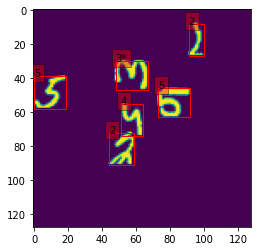

In [ ]:
mnist_canvas = get_random_canvas()
mnist_canvas.plot()

In [ ]:
mnist_canvas.boxes

[Mnist Box: x_min = 39, x_max = 58, y_min = 0, y_max = 19. Class = 5. Rotated = False.,
 Mnist Box: x_min = 46, x_max = 63, y_min = 73, y_max = 92. Class = 5. Rotated = False.,
 Mnist Box: x_min = 72, x_max = 91, y_min = 44, y_max = 59. Class = 2. Rotated = False.,
 Mnist Box: x_min = 55, x_max = 74, y_min = 51, y_max = 64. Class = 4. Rotated = False.,
 Mnist Box: x_min = 30, x_max = 47, y_min = 48, y_max = 67. Class = 3. Rotated = True.,
 Mnist Box: x_min = 8, x_max = 27, y_min = 91, y_max = 100. Class = 2. Rotated = False.]

In [ ]:
classes = [mnist_canvas.boxes[i].class_nb for i in range(len(mnist_canvas.boxes))]

In [ ]:
classes

[5, 5, 2, 4, 3, 2]

Now - let us generate test canvas:

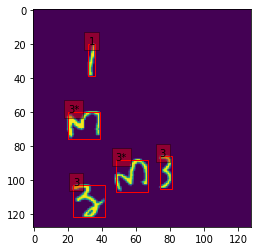

In [ ]:
TEST_CANVAS_SIZE = 256
TEST_SEED = 42 # DO NOT CHANGE THIS LINE.

np.random.seed(TEST_SEED)

TEST_CANVAS = [
    get_random_canvas(
        digits=TEST_DIGITS,
        classes=TEST_CLASSES,
    )
    for _ in range(TEST_CANVAS_SIZE)
]

TEST_CANVAS[0].plot()

In [ ]:
TRAIN_CLASSES

array([5, 0, 4, ..., 6, 9, 7], dtype=uint8)

In [ ]:
mnten = mnist_canvas.get_torch_tensor()

In [ ]:
mnten.shape

torch.Size([1, 1, 128, 128])

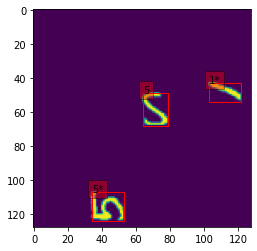

In [ ]:
TRAIN_CANVAS_SIZE = 256
#TRAIN_SEED = 42 # DO NOT CHANGE THIS LINE.

# np.random.seed(TRAIN_SEED)

TRAIN_CANVAS = [
    get_random_canvas(
        digits=TRAIN_DIGITS,
        classes=TRAIN_CLASSES,
    )
    for _ in range(TRAIN_CANVAS_SIZE)
]

TRAIN_CANVAS[0].plot()

For training one can either:
- generate `TRAIN_CANVAS` similarly to `TEST_CANVAS` creation,
- use the fact that `get_random_canvas()` generates a random train canvas and generate training data on-the-fly.

### Anchor size analysis (2pts)

For this task:
1. Sample at least 1000 random canvas.
2. Analyze the sizes (heights and widths) of the `MnistBox`es from this canvas.
3. Select the anchor sizes which will match the problem the best.

Selected anchor sizes should be stored in a sensible manner in `ANCHOR_SIZES` list.

In [ ]:
import collections
import matplotlib.pyplot as plt

xs = []
ys = []
alls = []
for i in range(1000):
  canva = get_random_canvas()
  boxes = canva.boxes
  for box in boxes:
    x_size = box.x_max - box.x_min
    y_size = box.y_max - box.y_min
    xs.append(x_size)
    ys.append(y_size)
    alls.append((x_size, y_size))



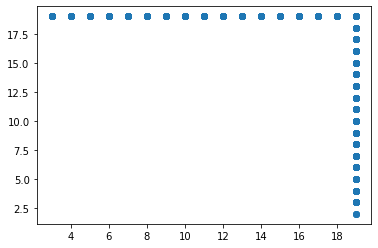

In [ ]:
plt.scatter(xs, ys)

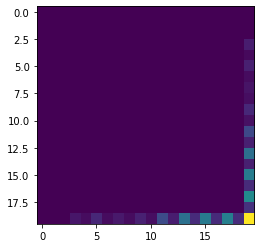

In [ ]:
import pandas as pd
alls = pd.DataFrame(alls)
alls.columns = ['x', 'y']

counts = pd.DataFrame(alls[['x', 'y']].value_counts())
counts.reset_index(inplace=True)
counts.columns = ['x', 'y', 'count']
heat = np.zeros((20,20))
for x in alls['x'].unique():
  for y in alls.loc[alls['x']== x, 'y'].unique():
    heat[x, y] = counts.loc[(counts['x']==x) & (counts['y'] == y)]['count']
    
plt.imshow(heat)

In [ ]:
alls = pd.DataFrame(alls)
alls.columns = ['x', 'y']
pairs = pd.DataFrame(alls[['x', 'y']].value_counts())
pairs.reset_index(inplace=True)
pairs['anchor'] = [(x, y) for x, y in zip(pairs['x'], pairs['y'])]

In [ ]:
pairs #.sort_values('anchor')

,x,y,0,anchor
0,19,19,789,"(19, 19)"
1,17,19,379,"(17, 19)"
2,19,17,340,"(19, 17)"
3,15,19,331,"(15, 19)"
4,19,15,324,"(19, 15)"
5,19,13,290,"(19, 13)"
6,13,19,289,"(13, 19)"
7,19,11,182,"(19, 11)"
8,11,19,171,"(11, 19)"
9,18,19,113,"(18, 19)"


In [ ]:
## mniejsza ilość wartości  najlepiej pokrywająca większość przypadków w zasięgu 3-3
ANCHOR_SIZES = [(22,22),(19,19),(17,19), (19, 17), (19,15), (15,19), (13, 19), (19,13), (9,19), (19,9), (19,5), (5,19)]
print("ANCHOR_SIZES:", ANCHOR_SIZES)

ANCHOR_SIZES: [(22, 22), (19, 19), (17, 19), (19, 17), (19, 15), (15, 19), (13, 19), (19, 13), (9, 19), (19, 9), (19, 5), (5, 19)]


In [ ]:
len(ANCHOR_SIZES)

12

### Model building descr 


One should build a model for digit detection in $\texttt{pytorch}$. Model should consist of:


#### $\texttt{backbone}$:

We provided you with a backbone model architecture that accepts a `MnistCanvas` instance and output a tensor with shape $(1, 16, 16, 128)$. It should be trained together with the rest of your solution.

#### $\texttt{anchors}$:

List of `MnistBox`es where each box:

- should have size of one of selected `ANCHOR_SIZES`,
- should have center coordinates on canvas of type $\left(\left(m + \frac{1}{2}\right) * 8, \left(n + \frac{1}{2}\right) * 8\right)$  for $m, n \in \{0, 1, \dots, 16 - 1\}$,

`MnistBox` with anchor should have an attribute `class_nb` set to `None`.

#### $\texttt{digitClassificationHead}$:

$\texttt{digitClassificationHead}$ should accept backbone output as an input and output `digit_classification_output` tensor of shape $(len(\texttt{anchors)}, 5)$ where the value $ch_{i, j}$ which is the value of i-th row and j-th column has a property that $sigmoid(ch_{i, j})$ is a probability that i-th anchor from $\texttt{anchors}$ overlaps significantly with some canvas `GTBox: MnistBox` with a digit of class $j + 1$ (ground truth box).

#### $\texttt{rotationClassificationHead}$:

$\texttt{rotationClassificationHead}$ should accept backbone output as an input and output `rotation_classification_output` tensor of shape $(len(\texttt{anchors)}, 2)$ where the value $ch_{i, j}$ which is the value of i-th row and j-th column has a property that $sigmoid(ch_{i, j})$ is a probability that i-th anchor from $\texttt{anchors}$ overlaps significantly with some canvas `GTBox: MnistBox` with a digit which was not rotated when $j = 0$ and was rotated when $j = 1$.

#### $\texttt{boxRegressionHead}$:

$\texttt{boxRegressionHead}$ should accept backbone output as an input and output `box_regression_output` tensor of shape $(len(\texttt{anchors)}, 4)$ where the value $br_{i}$ which is the value of i-th row has a property that if there is a ground truth digit box $\texttt{GTBox}$ - significantly overlapping with $\texttt{anchor}[i]$ then the following properties hold:

$$\texttt{GTBox.x_min} = \texttt{anchor[i].x_min} + br_{i, 0},$$ 
$$\texttt{GTBox.x_max} = \texttt{anchor[i].x_max} + br_{i, 1},$$ 
$$\texttt{GTBox.y_min} = \texttt{anchor[i].y_min} + br_{i, 2},$$ 
$$\texttt{GTBox.y_max} = \texttt{anchor[i].y_max} + br_{i, 3}.$$ 

#### *Hint*: be careful with a construction of a head output as a simple reshaping might cause unexpected permutation of anchors.

### Model output

Model should output `DigitDetectionModelOutput` class defined below.

#### Comment on _significant overlap_:

The meaning of significant overlap will be described later.

### Model building (2pt)

In [ ]:
# set centers

def set_centers(num=16):
  centers = []
  for m in range(num):
    for n in range(num):
      center = ((m+0.5)*8 , (n+0.5)*8)
      centers.append(center)
  return centers

In [ ]:
def set_anchors(centers, ANCHOR_SIZES):
  anchors = []

  for center in centers:
    for size in ANCHOR_SIZES:
      x_min = center[0] - int(0.5 * (size[0]))
      x_max = center[0] + int(0.5 * (size[0]))
      y_min = center[1] - int(0.5 * (size[1]))
      y_max = center[1] + int(0.5 * (size[1]))
      box = MnistBox(x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
      anchors.append(box)
  return anchors

In [ ]:
centers = set_centers()
anchors = set_anchors(centers, ANCHOR_SIZES)

In [ ]:
len(anchors)

3072

In [ ]:
class digitClassificationHead(torch.nn.Module): 
    """digitClassificationHead  should accept backbone output as an input and output digit_classification_output tensor of shape  (len(anchors),5) 
    where the value  chi,j  which is the value of i-th row and j-th column has a property that  sigmoid(chi,j)  is a probability that
      i-th anchor from  anchors  overlaps significantly with some canvas GTBox: MnistBox with a digit of class  j+1  (ground truth box)."""
    def __init__(self, out_size): #out_size = (len(anchors),5) 
      super().__init__()
      self.layers= []
      for _ in range(3):
        self.layers.append(nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1))
        self.layers.append(nn.ReLU(True))
      self.layers.append(nn.Conv2d(128, out_size, kernel_size=3, stride=1, padding=1))
      self.layers = nn.Sequential(*self.layers)


    def forward(self,x):
      out = self.layers(x)
      
      return out


class rotationClassificationHead(torch.nn.Module):
    """rotationClassificationHead  should accept backbone output as an input and output rotation_classification_output tensor of shape  (len(anchors),2) 
    where the value  chi,j  which is the value of i-th row and j-th column has a property that  sigmoid(chi,j)  
    is a probability that i-th anchor from  anchors  overlaps significantly with some canvas GTBox: MnistBox with a digit which was not rotated when  j=0  and was rotated when  j=1 ."""
    def __init__(self, out_size): #out_size = (len(anchors),2) 
      super().__init__()
      self.layers= []
      for _ in range(3):
        self.layers.append(nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1))
        self.layers.append(nn.ReLU(True))
      self.layers.append(nn.Conv2d(128, out_size, kernel_size=3, stride=1, padding=1))
      self.layers = nn.Sequential(*self.layers)
      

    def forward(self,x):
      out = self.layers(x)
      return out


class boxRegressionHead(torch.nn.Module): 
    """boxRegressionHead  should accept backbone output as an input and output box_regression_output tensor of shape  (len(anchors),4) 
    where the value  bri  which is the value of i-th row has a property that if there is a ground truth digit box  GTBox  - significantly overlapping with  anchor[i]  then the following properties hold:
      GTBox.x_min=anchor[i].x_min+bri,0, 
      GTBox.x_max=anchor[i].x_max+bri,1, 
      GTBox.y_min=anchor[i].y_min+bri,2, 
      GTBox.y_max=anchor[i].y_max+bri,3. 
    Hint: be careful with a construction of a head output as a simple reshaping might cause unexpected permutation of anchors."""
    def __init__(self, out_size):
      super().__init__()
      self.layers= []
      for _ in range(3):
        self.layers.append(nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1))
        self.layers.append(nn.ReLU(True))
      self.layers.append(nn.Conv2d(128, out_size, kernel_size=3, stride=1, padding=1))
      self.layers = nn.Sequential(*self.layers)

    def forward(self,x):
      out = self.layers(x)
      return out

In [ ]:
from torch import nn

class DigitDetectionModelOutput:

    def __init__(
        self,
        anchors: List[MnistBox],
        digit_classification_output: torch.Tensor,
        rotation_classification_output: torch.Tensor,
        box_regression_output: torch.Tensor,
    ):
        self.anchors = anchors
        self.digit_classification_output = digit_classification_output
        self.box_regression_output = box_regression_output
        self.rotation_classification_output = rotation_classification_output


class Backbone(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.output_shape = (16, 16, 128)
        self.first_block = torch.nn.Sequential(
            nn.Conv2d(1, 16, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, (3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.blocks = torch.nn.ModuleList(
            [torch.nn.Sequential(*[
                nn.Conv2d(16 * (2 ** i), 16 * (2 ** (i + 1)), (3, 3), padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
              ]) for i in range(1, 3)
            ]
        )

    def forward(self, x: MnistCanvas) -> torch.Tensor:
        image = torch.Tensor(x.image).to(DEVICE).view(1, 1, 128, 128)
        aux = self.first_block(image)
        for block in self.blocks:
            aux = block(aux)
        return aux


class DigitDetectionModel(nn.Module):

    def __init__(self, anchors):
      super(DigitDetectionModel, self).__init__()
      self.num_size = int(len(anchors) /256)     # number of anchors for one center
      self.num_anchors = 16*16* self.num_size  #number of centers*sizes
      self.backbone = Backbone()
      self.cla_head = digitClassificationHead(out_size= 5*self.num_size)     # out_size = (len(anchors),5 classes) 
      self.rot_head = rotationClassificationHead(out_size= 2*self.num_size)  # out_size = (len(anchors),2) 
      self.box_head = boxRegressionHead(4*self.num_size)           # (len(anchors),4) 
      self.heads = [self.cla_head, self.rot_head, self.box_head]

    def forward(self, x: MnistCanvas, anchors) -> DigitDetectionModelOutput:
      bbs = self.backbone(x)
      cla = self.cla_head(bbs)
      rot = self.rot_head(bbs)
      box = self.box_head(bbs)
      cla = cla.permute(0,2,3,1)   # batch_size, 16, 16, out_size
      cla = cla.reshape(self.num_anchors, 5)
      rot = rot.permute(0,2,3,1) 
      rot = rot.reshape(self.num_anchors, 2)
      box = box.permute(0,2,3,1)
      box = box.reshape(self.num_anchors, 4)
      return DigitDetectionModelOutput(anchors, cla, rot, box) # should be DigitDetectionModelOutput !!! need to keep anchors



### Targets and predictions

#### Significant overlap (4pt)

In order to manage definition of a _significant overlap_ student should implement the `TargetDecoder`. `TargetDecoder` have two methods:

#### - `get_targets`

This method accepts a `canvas: MnistCanvas` with boxes later refered to as `gt_boxes: List[MnistBox]`, `anchors: List[MnistBox]` of model anchors and `iou_threshold: float`. Its output should be `DigitDetectionModelTarget` instance with the following attributes:

- `digit_classification_target` - a tensor of shape $(len(anchors), 5)$,
- `rotation_classification_target` - a tensor of shape $(len(anchors), 2)$
- `box_regression_target` - a tensor of shape $(len(anchors), 4)$,
- `matched_anchors` - a list of indices anchors matched (see definition below).

The output attributes should be computed in a following manner: 

1. All of the outputs of the output tensors should be `0` except the case presented in the point 2.
1. if for anchor `anchors[i]` there exist at least one `gt_box` from `gt_boxes` with `iou` overlap greater than `iou_threshold` then let `gt_best` be the one with the greatest `iou` overlap (ties resolved randomly). Then `box_regression_target` should encode the bounding box correction, namely:

$$\texttt{box_regression_target}[i, 0] = \texttt{gt_best.x_min} - \texttt{anchor[i].x_min}$$ 
$$\texttt{box_regression_target}[i, 1] = \texttt{gt_best.x_max} - \texttt{anchor[i].x_max}$$ 
$$\texttt{box_regression_target}[i, 2] = \texttt{gt_best.y_min} - \texttt{anchor[i].y_min}$$ 
$$\texttt{box_regression_target}[i, 3] = \texttt{gt_best.y_max} - \texttt{anchor[i].y_max}$$,

`digit_classification_target` should encode the class of matched `gt_best`, namely:

$$\texttt{digit_classification_target}[i, \texttt{gt_best.class_nb} - 1] = 1.$$

`rotation_classification_target` should encode if matched `gt_best` has a digit which was rotated, namely:

$$\texttt{rotation_classification_target}[i, 0] = 1,$$

if `gt_best` digit was not rotated and:

$$\texttt{rotation_classification_target}[i, 1] = 1,$$

if `gt_best` digit was rotated (this might be interpreted as a one-hot encoding if a digit was rotated).

Moreover - the `anchor[i]` is considered to be _matched_ with some ground truth box so index `i` should be in `matched_anchors` list.

The output should be packed into `DigitDetectionModelTarget` class defined below.

_Hint_: note that there might be cases when no anchor is matched. What does it mean about your anchors?

#### - `get_predictions`

This method should decode the `DigitDetectionModelOutput` to set of final boxes
predictions. We leave the way of selecting the predictions to students.

_HINT_: we definitely advise to use `torchvision.ops.nms` function.



In [ ]:
from torchvision.ops import box_iou, nms
import torch.nn.functional as F


class DigitDetectionModelTarget:

    def __init__(
        self,
        digit_classification_target: torch.Tensor,
        rotation_classification_target: torch.Tensor,
        box_regression_target: torch.Tensor,
        matched_anchors: List[int],
    ):
        self.digit_classification_target = digit_classification_target
        self.rotation_classification_target = rotation_classification_target
        self.box_regression_target = box_regression_target
        self.matched_anchors = matched_anchors



class TargetDecoder:

    def get_targets(
        self,
        canvas: MnistCanvas,
        anchors: List[MnistBox],
        iou_threshold: float=0.2,
        nb_of_classes: int = 5,
    ) -> DigitDetectionModelTarget:
        gt_boxes = canvas.boxes
        digit_classification_target, rotation_classification_target, box_regression_target, matched_anchors = self.match_anchors(anchors, gt_boxes, iou_threshold, nb_of_classes)
        return DigitDetectionModelTarget(digit_classification_target, rotation_classification_target, box_regression_target, matched_anchors)

    def match_anchors(self, anchors, gt_boxes, iou_threshold, nb_of_classes):     
        # classes
        classes = torch.zeros(len(anchors),5, dtype=torch.int64) # set all boxes to [0,0,0,0,0]
        gt_classes = [gt_boxes[i].class_nb - 1 for i in range(len(gt_boxes))]
        gt_classes = torch.tensor(gt_classes, dtype=torch.int64)
        gt_classes = F.one_hot(gt_classes, num_classes=5)
        # rotation
        rotation = torch.zeros(len(anchors), 2, dtype=torch.int64)
        gt_rotation = torch.Tensor([int(gt_boxes[i].rotated) for i in range(len(gt_boxes))])
        gt_rotation = F.one_hot(gt_rotation.to(torch.int64), num_classes=2)
        # box regression
        box_regression = torch.zeros(len(anchors), 4, dtype=torch.int64)
        # matched anchors
        matched_anchors = []
        for gi, gt_box in enumerate(gt_boxes):
            threshold = iou_threshold
            max_index = 0
            best_box = None
            for i, anchor in enumerate(anchors):
                iou = gt_box.iou_with(anchor)
                if iou > threshold:
                    threshold = iou
                    best_box = anchor
                    max_index = i
            classes[max_index] = gt_classes[gi]
            rotation[max_index] = gt_rotation[gi]
            matched_anchors.append(max_index)
            brx_min = gt_box.x_min - anchors[max_index].x_min
            brx_max = gt_box.x_max - anchors[max_index].x_max
            bry_min = gt_box.y_min - anchors[max_index].y_min
            bry_max = gt_box.y_max - anchors[max_index].y_max
            regress = torch.tensor([brx_min, brx_max, bry_min, bry_max])
            box_regression[max_index] = regress
        
        return classes, rotation, box_regression, matched_anchors



    def get_predictions(
        self,
        model_output: DigitDetectionModelOutput,
    ) -> List[MnistBox]:
        """This method should decode the DigitDetectionModelOutput to set of final boxes predictions.
         We leave the way of selecting the predictions to students.
        HINT: we definitely advise to use torchvision.ops.nms function."""
        # klasy ktore maja najwieksze prawdopodobiensta 
        class_threshold = 0.21
        # nms --
        final_boxes = []
        boxes = []
        m = nn.Sigmoid()
        classes_prob = m(model_output.digit_classification_output)
        # classes_prob = torch.nn.functional.softmax(model_output.digit_classification_output)
        max_digits, class_inds = torch.max(classes_prob, axis=1)
        indices = torch.arange(0, len(model_output.anchors))
        max_inds_anchors = indices[max_digits > class_threshold]
        rotations = model_output.digit_classification_output

        # przesuwam o te br cos regresje       
        # for digit in [1,2,3,4,5]:
        digit_boxes = []
        digit_scores = []
        digit_rotations = []
        digit_classes = []
        keep_inds = []
        for i, ind in enumerate(max_inds_anchors):
            class_nb = model_output.digit_classification_output[ind]
            # if class_nb == digit:
            anchor = model_output.anchors[ind]
            br = model_output.box_regression_output[ind]
            rotation = model_output.rotation_classification_output[ind]
            x_min = anchor.x_min + br[0]
            x_max  = anchor.x_max + br[1]
            y_min = anchor.y_min + br[2]
            y_max = anchor.y_max + br[3]
            box = [x_min, y_min,  x_max, y_max]
            digit_classes.append(class_nb)
            digit_boxes.append(box)
            digit_scores.append(max_digits[i])
            digit_rotations.append(rotation)

        digit_boxes = torch.tensor(digit_boxes)
        digit_scores = torch.tensor(digit_scores)
        if len(digit_boxes) > 0:
            sign = torch.sign(digit_scores)
            # digit_scores =  digit_scores + 10*torch.ones(digit_scores.shape)
            keep_inds = torchvision.ops.nms(digit_boxes, digit_scores, iou_threshold=0.1)
        for keep in keep_inds:
            box = digit_boxes[keep]
            rotation = digit_rotations[keep]
            rotation = torch.argmax(rotation)
            digit = digit_classes[keep]
            digit = torch.argmax(digit) + 1
            rotation = bool(rotation)
            mnist_box = MnistBox(x_min=box[0], x_max=box[2], y_min=box[1], y_max=box[3], class_nb=digit, rotated=rotation)
            final_boxes.append(mnist_box)

        return final_boxes
        


### Metrics

#### Metrics (4pt)

## Retina Loss
As a loss function one should implement the variant of Retina Loss. It should be computed in a following manner:

`compute_loss`: 

This method accepts:
- `DigitDetectionModelTarget`,
- `DigitDetectionModelOutput`,

and computes a loss which is a sum of a:
- `torch.nn.SmoothL1Loss` between boxes predictions and targets averaged only over matched anchors,
- `torchvision.ops.sigmoid_focal_loss` between digit predictions and targets,
- `torchvision.ops.sigmoid_focal_loss` between rotation predictions and targets,

One can either use `torch` default parameters for this losses or try to tune them.

If there are no matched anchors - a loss should return `None`. Remember to handle this case separately in your training loop. What does the occurence of this case means about your anchors?

## Digit Accuracy

This method shoud accept `canvas: MnistCanvas` and `predicted_boxes: List[MnistBox]` obtained using `TargetDecoder.get_predictions` method and output whether there is a direct matching between boxes from `MnistCanvas` and predictions. There is a direct matching if:

- for all boxes from `canvas`, there exist precisely one box from `predicted_boxes` with a matching class  and `iou` overlap greater than `0.5`,
- the number of `canvas` boxes match `len(predicted_boxes)`.

The model shoud output `1` if there is a matching and `0` otherwise.


In [ ]:
import torch
import torchvision 
import torch.nn.functional as F


class RetinaLoss(nn.Module):

    def __init__(self, num_classes=5):
        super(RetinaLoss, self).__init__()
        self.num_classes = num_classes

    def compute_loss(
        self,
        model_output: DigitDetectionModelOutput,
        model_target: DigitDetectionModelTarget,
    ) -> Optional[torch.Tensor]:

        """computes a loss which is a sum of a:
        torch.nn.SmoothL1Loss between boxes predictions and targets averaged only over matched anchors,
        torchvision.ops.sigmoid_focal_loss between digit predictions and targets,
        torchvision.ops.sigmoid_focal_loss between rotation predictions and targets,
        """
        # alpha = 0.25
        # gamma = 2
        inds = model_target.matched_anchors
        # box loss params
        box_target = model_target.box_regression_target[inds]
        box_output = model_output.box_regression_output[inds]
        smooth_loss = torch.nn.SmoothL1Loss()
        box_loss = smooth_loss(box_output, box_target)
        # digit loss params
        digit_loss = torchvision.ops.sigmoid_focal_loss(model_output.digit_classification_output, model_target.digit_classification_target.to(torch.float))
        rotation_loss = torchvision.ops.sigmoid_focal_loss(model_output.rotation_classification_output, model_target.rotation_classification_target.to(torch.float))
        # loss = box_loss + digit_loss + rotation_loss
        loss = box_loss + torch.sum(digit_loss) + torch.sum(rotation_loss)
        return loss



class DigitAccuracy:
 
    def compute_metric  (
        self,
        predicted_boxes: List[MnistBox],
        canvas: MnistCanvas,
    ):
        gt_boxes = canvas.boxes
        if len(gt_boxes) != len(predicted_boxes):
            return 0
        acc = 0
        for i, gt_box in enumerate(gt_boxes):
            for box in predicted_boxes:
                if box.iou_with(gt_box) >= 0.5: 
                    if box.class_nb == gt_box.class_nb: # check iou
                        if box.rotated == gt_box.rotated: # check rotation
                            acc += 1
                #         else: print('bad rotation')
                #     else: print('Wrong class')    
                # else: print(box.iou_with(gt_box))            
        if acc == len(gt_boxes):
            return 1
        else: return  0

### Train your model (4pt)

One should use all classes defined above to train the model.

A passing threshold is `10%` of a `DigitAccuracy` on a `TEST_CANVAS` data.

Plot example results of matched and mismatched predictions (2pt).

**Hint:** Training can take a while to achieve the expected accuracy. It is normal that for many epochs at the beginning accuracy is constantly $0$. Do not worry as long as the loss is on average decreasing across epochs.

Have fun!

#### Sets and anchors

## TRAIN MODEL

In [ ]:
def test(net, TEST_CANVAS=TEST_CANVAS):
    target_decoder = TargetDecoder()
    DACCS = []
    for example in TEST_CANVAS:    
        target = target_decoder.get_targets(example, anchors)
        net_output = net.forward(example, anchors)
        preds = target_decoder.get_predictions(net_output)
        dacc = digit_accuracy.compute_metric(preds, example)
        DACCS.append(dacc)
    acc = np.array(DACCS)
    accurate = sum(acc)
    ACC = accurate/len(acc)
    return ACC, DACCS

In [ ]:
## TRAIN A MODEL

In [ ]:
from torch import optim

# parameters to tune: alpha? & gamma?
lr = 0.0005

# set anchors
centers = set_centers()
anchors = set_anchors(centers, ANCHOR_SIZES)
print("Number of anchors {}".format(len(anchors)))

# initialize net
net = DigitDetectionModel(anchors)

# choose criterion, optimizer
criterion = RetinaLoss(num_classes=5)
optimizer = optim.SGD(net.parameters(),lr=lr, momentum=0.9, weight_decay=1e-3)

# target decoder
target_decoder = TargetDecoder()
digit_accuracy = DigitAccuracy()


examples_num=50000
# def train(examples_num=100000):
for example_id in range(1, examples_num + 1):
    net.train()
    example = get_random_canvas()
    target = target_decoder.get_targets(example, anchors)
    optimizer.zero_grad()
    net_output = net.forward(example, anchors)
    loss = criterion.compute_loss(net_output, target)
    if example_id%100 == 0:
        print(f"Example number: {example_id+1} , Loss: {loss}")
    loss.backward(retain_graph=True)
    optimizer.step()
    if example_id%100 == 0:
        preds = target_decoder.get_predictions(net_output)
        if len(preds) == 0:
            print("No box selected")
        else:
            dacc = digit_accuracy.compute_metric(preds, example)
            print('DIGIT ACCURACY:', dacc)
    if example_id%1000 == 0:
        acc, dacc = test(net)
        print("BOX ACCURACY:", acc)



Number of anchors 3072
Example number: 101 , Loss: 7.72116231918335
No box selected
Example number: 201 , Loss: 6.174076080322266
No box selected
Example number: 301 , Loss: 4.749958038330078
No box selected
Example number: 401 , Loss: 7.627176284790039
DIGIT ACCURACY: 0
Example number: 501 , Loss: 6.330646514892578
DIGIT ACCURACY: 0
Example number: 601 , Loss: 4.216523170471191
No box selected
Example number: 701 , Loss: 4.189319610595703
DIGIT ACCURACY: 0
Example number: 801 , Loss: 5.524035453796387
DIGIT ACCURACY: 0
Example number: 901 , Loss: 4.459214687347412
DIGIT ACCURACY: 0
Example number: 1001 , Loss: 7.025193214416504
DIGIT ACCURACY: 0
BOX ACCURACY: 0.00390625
Example number: 1101 , Loss: 6.514925003051758
DIGIT ACCURACY: 0
Example number: 1201 , Loss: 3.7541093826293945
DIGIT ACCURACY: 0
Example number: 1301 , Loss: 3.64451265335083
DIGIT ACCURACY: 0
Example number: 1401 , Loss: 6.7929887771606445
DIGIT ACCURACY: 0
Example number: 1501 , Loss: 7.183963775634766
DIGIT ACCURA

KeyboardInterrupt: ignored

In [ ]:
def test(net, TEST_CANVAS=TEST_CANVAS):
    target_decoder = TargetDecoder()
    digit_accuracy = DigitAccuracy() # tego nie było
    DACCS = []
    for example in TEST_CANVAS:    
        target = target_decoder.get_targets(example, anchors)
        net_output = net.forward(example, anchors)
        preds = target_decoder.get_predictions(net_output)
        dacc = digit_accuracy.compute_metric(preds, example)
        DACCS.append(dacc)
    acc = np.array(DACCS)
    accurate = sum(acc)
    ACC = accurate/len(acc)
    return ACC, DACCS

### EXAMPLES FROM DIFFERENT STAGES OF LEARNING

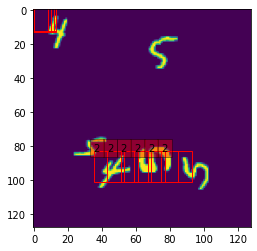

In [ ]:
example.plot(outs) # after 100 step - concentrates on area where digits are, Model fist learns where the digits are

### CANVAS TEST

### BOX ACCURACY

In [ ]:
# TEST BOX ACCURACY AFTER 10.000 samples training
acc, dacc = test(net) # after 10000th iteration

In [ ]:
print("FINAL Digit Accuracy", acc)

FINAL Digit Accuracy 0.359375


### Misclassified example

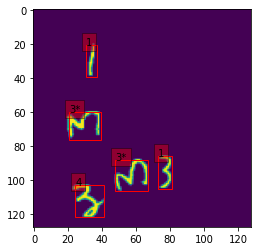

In [ ]:
centers = set_centers()
anchors = set_anchors(centers, ANCHOR_SIZES)
target_decoder = TargetDecoder()
example = TEST_CANVAS[0]
target = target_decoder.get_targets(example, anchors)
net_output = net.forward(example, anchors)
preds = target_decoder.get_predictions(net_output)
example.plot(preds)

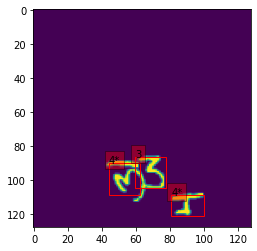

In [ ]:
centers = set_centers()
anchors = set_anchors(centers, ANCHOR_SIZES)
target_decoder = TargetDecoder()
example = TEST_CANVAS[3]
target = target_decoder.get_targets(example, anchors)
net_output = net.forward(example, anchors)
preds = target_decoder.get_predictions(net_output)
example.plot(preds)


In [ ]:
centers = set_centers()
anchors = set_anchors(centers, ANCHOR_SIZES)
target_decoder = TargetDecoder()
example = TEST_CANVAS[3]
target = target_decoder.get_targets(example, anchors)
net_output = net.forward(example, anchors)
preds = target_decoder.get_predictions(net_output)
example.plot(preds)

0

### well classified examples

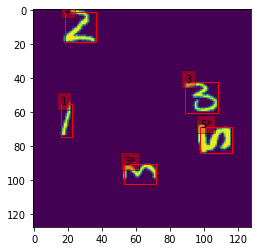

In [ ]:
centers = set_centers()
anchors = set_anchors(centers, ANCHOR_SIZES)
target_decoder = TargetDecoder()
example = TEST_CANVAS[9]
target = target_decoder.get_targets(example, anchors)
net_output = net.forward(example, anchors)
preds = target_decoder.get_predictions(net_output)
example.plot(preds)

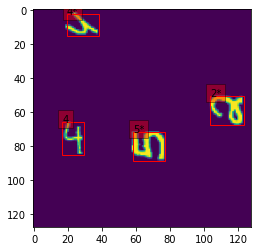

In [ ]:
centers = set_centers()
anchors = set_anchors(centers, ANCHOR_SIZES)
target_decoder = TargetDecoder()
example = TEST_CANVAS[10]
target = target_decoder.get_targets(example, anchors)
net_output = net.forward(example, anchors)
preds = target_decoder.get_predictions(net_output)
example.plot(preds)

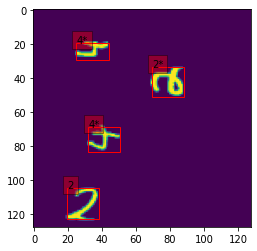

In [ ]:
centers = set_centers()
anchors = set_anchors(centers, ANCHOR_SIZES)
target_decoder = TargetDecoder()
example = TEST_CANVAS[91]
target = target_decoder.get_targets(example, anchors)
net_output = net.forward(example, anchors)
preds = target_decoder.get_predictions(net_output)
example.plot(preds)

Summing up we set 12 anchors in each center to train DigitDetectonModel. It went much easier with training quite good located boxes, but it took much longer to train correct digit classes detection.
First model trained only on 9 anchors/center was struggling to train boxes. 
Also it is hard to adjust good threshold for the accepted boxes in the predicted_boxes. It is hard to boost the DigitAccuracy since some classes are also irrecognizable when they are close to each other. The model performs worse when the digits are located close to each other as it was shawn above